In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from latticeproteins.fitness import Fitness
from latticeproteins.interactions import miyazawa_jernigan
from latticeproteins.sequences import RandomSequence, NMutants
from latticeproteins.conformations import Conformations

from gpmap.utils import hamming_distance
from gpmap.utils import AMINO_ACIDS

from latticegpm.gpm import LatticeGenotypePhenotypeMap

In [21]:
class EvolverError(Exception):
    """"""

def adaptive_walk(seq, n_mutations, temp=1.0, target=None):
    """
    """
    length = len(seq)
    c = Conformations(length, "database")
    dGdependence = "fracfolded"

    wildtype = seq
    mutant = list(wildtype)

    indices = list(range(len(wildtype)))    
    path = [wildtype]

    # Get native structure
    fitness = Fitness(temp, c, dGdependence=dGdependence)
    wt_structure = fitness._NativeE(wildtype)[1]

    # Start evolving
    hamming = 0
    while hamming < n_mutations:
        # Calculate stability of all amino acids at all sites
        AA_grid = np.array([AMINO_ACIDS]*length)
        dG = np.zeros(AA_grid.shape, dtype=float)
        for (i,j), AA in np.ndenumerate(AA_grid):
            seq1 = mutant[:]
            seq1[i] = AA_grid[i,j]
            dG[i,j] = fitness.Fitness(seq1)

        # Find the max dG
        x, y = np.where(dG == dG.max())
        best_AA = AA_grid[x[0], y[0]]
        mut = mutant[:]
        mut[x[0]] = best_AA
        
        # Determine native structure mutant
        mut_structure = fitness._NativeE(mut)[1]
        new_hamming = hamming_distance(wildtype, mut)
        
        # Accept move if native structure is maintained and hamming distance increases
        if mut_structure == wt_structure and new_hamming > hamming:
            path.append("".join(mut[:]))
            mutant = mut
            hamming = new_hamming
        else:
            raise EvolverError("No adaptive paths n_mutations away.")
            
    return path


def find_walk(length, n_mutations):
    """Find an adaptive walk in lattice sequence space."""
    while True:
        try:
            wildtype = "".join(RandomSequence(12))
            path = adaptive_walk(wildtype, 8)
            break
        except EvolverError:
            pass
    return path

In [25]:
import time
start = time.time()
for i in range(10):
    find_walk(12, 7)
stop = time.time()
print(stop-start)

9.921941757202148


In [ ]:
i = 0
nmax = 100

f = open("sequences-2.txt", "w")
    
while i < nmax:
    try:
        wildtype = "".join(RandomSequence(12))
        path = adaptive_walk(wildtype, 8)
        lpath = len(path)
        mutant = path[-1]
        if lpath == 9:
            i += 1
            s = wildtype+","+mutant+"\n"
            f.write(s)
    except:
        pass
    
f.close()

In [65]:
wildtype, mutant
gpm = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c)

In [66]:
print(gpm.confs[0], gpm.confs[-1])

UURDDDLLUUU UURDDDLLUUU


# Fit epistasis model

In [67]:
from epistasis.models import EpistasisLinearRegression
from epistasis.simulate import LinearSimulation
from epistasis.stats import pearson

def calculate_phi(model):
    """Calculate the fraction of the phenotypes explained by (statistical) epistasis."""
    # Quick check.
    if model.model_type != "global":
        raise Exception("Argument must be a global model.")
    model.gpm.phenotype_type = "stabilities"
    r2 = [0]
    for i in range(1,9):
        em = model.epistasis.get_orders(*list(range(i+1)))
        sim = LinearSimulation.from_coefs(
            model.gpm.wildtype,
            model.gpm.mutations,
            em.labels,
            em.values,
            model_type=model.model_type)
        r = pearson(sim.phenotypes, model.gpm.phenotypes)**2
        r2.append(r)
    fx = [r2[i] - r2[i-1] for i in range(2, len(r2))]
    fx = [1 - sum(fx)] + fx
    return fx

In [68]:
np.unique(gpm.confs)

array(['UURDDDLLUUU', 'UURDRDLDLLU'], 
      dtype='<U11')

In [69]:
gpm.phenotype_type = "stabilities"
gmodel = EpistasisLinearRegression.from_gpm(gpm, order=8, model_type="global")
gmodel.fit()

calculate_phi(gmodel)

/home/zsailer/virtual/py3/lib/python3.5/site-packages/sklearn/base.py:175: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  args, varargs, kw, default = inspect.getargspec(init)


[0.8781289346358192,
 0.10741836163004181,
 0.01248011656759207,
 0.0017509876703697413,
 0.00020503446250841328,
 1.5818514933818584e-05,
 7.3063956929075857e-07,
 1.5879165649046456e-08]

# Plot the networks

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
from latticeproteins.conformations import Conformations
from latticegpm.gpm import LatticeGenotypePhenotypeMap
from gpmap.graph import draw
from latticegpm.search import get_lowest_confs

from gpmap.evolve.models import fixation
from gpmap.graph.paths import paths_and_probabilities, path_probabilities
from gpmap.graph.draw.paths import flux
from gpmap.graph.draw.base import network

In [57]:
c = Conformations(12, database_dir="database")

In [28]:
def edge_flux(G, source, target, width_scale=10, ax=None, figsize=(5,5), **settings):
    """
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig=None
        #fig = ax.get_figure()
    # Calculate fluxes on edges
    fluxes = flux(G, source, target)

    # Settings to the network
    defaults = dict(
        figsize=[2.5,2.5],
        n_height=9,
        n_width=9,
        n_linewidths=0,
        n_vmax=round(max(G.gpm.phenotypes),2),
        n_vmin=round(max(G.gpm.phenotypes),2),
        n_colorbar=True,
        e_arrows=False,
        l_alpha=0.0,
    )
    defaults.update(**settings)
    fig, ax, pos = network(G, e_width=width_scale*fluxes, ax=ax, **settings)
    return fig, ax

In [32]:
def draw_networks(G, G2, G3):
    """Draws three networks in one column."""

    fig = plt.figure(figsize=(12,9))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(hspace=0)
    ax1 = plt.subplot(gs1[0, :])
    ax2 = plt.subplot(gs1[1, :])
    ax3 = plt.subplot(gs1[2, :])

    # FULL STATE
    s = dict(
        n_height=5,
        n_width=8,
        e_arrows=False,
        e_width=.2,
        e_edge_color="k",
        e_alpha=.5,
        l_font_size=6,
        l_alpha=0,
    )

    x = draw.network(G, ax=ax1, **s)

    # 2-STATE 
    s = dict(
        n_height=5,
        n_width=8,
        e_arrows=False,
        e_edge_color="k",
        e_alpha=.5,
        l_font_size=7,
        l_alpha=0,
    )

    x = edge_flux(G2, source, target, ax=ax2, **s)

    # 3-STATE
    s = dict(
        n_height=5,
        n_width=8,
        e_arrows=False,
        e_edge_color="k",
        e_alpha=.5,
        l_font_size=7,
        l_alpha=0,
    )

    x = edge_flux(G3, source, target, ax=ax3, **s)
    
    return fig

In [33]:
def make_network_figure(wildtype, mutant):
    """"""

    # Build spaces
    cs = get_lowest_confs(wildtype, 3, database="database")
    gpm = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c)
    gpm.phenotype_type = "fracfolded"
    G = gpm.add_networkx()
    G.add_evolutionary_model(fixation)

    gpm2 = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c)
    gpm2.set_partition_confs(cs[0:2])
    gpm2.phenotype_type = "fracfolded"
    G2 = gpm2.add_networkx()
    G2.add_evolutionary_model(fixation)

    gpm3 = LatticeGenotypePhenotypeMap.from_mutant(wildtype, mutant, c)
    gpm3.set_partition_confs(cs)
    gpm3.phenotype_type = "fracfolded"
    G3 = gpm3.add_networkx()
    G3.add_evolutionary_model(fixation)

    # Calculate paths
    mapping = gpm.map("genotypes", "indices")
    source = mapping[wildtype]
    target = mapping[mutant]

    mapping = gpm2.map("genotypes", "indices")
    source2 = mapping[wildtype]
    target2 = mapping[mutant]

    mapping = gpm3.map("genotypes", "indices")
    source3 = mapping[wildtype]
    target3 = mapping[mutant]

    fig = plt.figure(figsize=(12,9))
    gs1 = gridspec.GridSpec(3, 3)
    gs1.update(hspace=0)
    ax1 = plt.subplot(gs1[0, :])
    ax2 = plt.subplot(gs1[1, :])
    ax3 = plt.subplot(gs1[2, :])

    # FULL STATE
    s = dict(
        n_height=5,
        n_width=8,
        e_arrows=False,
        e_width=.2,
        e_edge_color="k",
        e_alpha=.5,
        l_font_size=6,
        l_alpha=0,
    )

    x = draw.network(G, ax=ax1, **s)

    # 2-STATE 
    s = dict(
        n_height=5,
        n_width=8,
        e_arrows=False,
        e_edge_color="k",
        e_alpha=.5,
        l_font_size=7,
        l_alpha=0,
    )

    x = edge_flux(G2, source2, target2, ax=ax2, **s)

    # 3-STATE
    s = dict(
        n_height=5,
        n_width=8,
        e_arrows=False,
        e_edge_color="k",
        e_alpha=.5,
        l_font_size=7,
        l_alpha=0,
    )

    x = edge_flux(G3, source3, target3, ax=ax3, **s)
    
    return fig

/home/zsailer/github/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


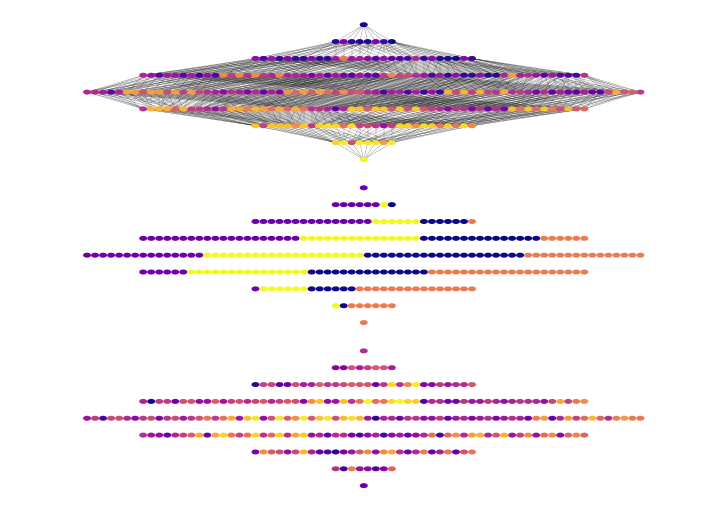

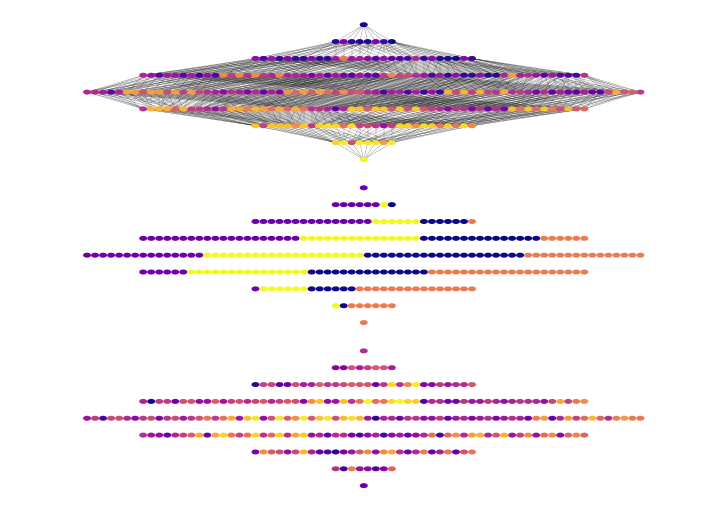

In [34]:
make_network_figure(wildtype, mutant)